<a href="https://colab.research.google.com/github/Salvoaf/BreastCancerClassification/blob/main/Preporcessing_and_treaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import files
files.upload()
!pip install kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip

In [4]:
import os
from google.colab import drive
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D

This is a code snippet in Python. The line 'breast_img = glob.glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive = True)' uses the glob library to search for all .png files in the directory '/content/IDC_regular_ps50_idx5/' and all its subdirectories, by setting the 'recursive' argument to True.

The for loop then iterates over the first three elements of the 'breast_img' list, which contain the file names of the .png files found by the glob function, and prints each file name.

In [6]:
breast_img = glob.glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/content/IDC_regular_ps50_idx5/10277/1/10277_idx5_x1251_y1351_class1.png
/content/IDC_regular_ps50_idx5/10277/1/10277_idx5_x1251_y1551_class1.png
/content/IDC_regular_ps50_idx5/10277/1/10277_idx5_x851_y1351_class1.png


This code creates two empty lists, 'N_IDC' and 'P_IDC', and then uses a for loop to iterate over the list 'breast_img', which contains file names of .png images.

For each image file name in the list, the code checks the 5th character from the end of the file name. If the character is '0', the file name is appended to the 'N_IDC' list. If the character is '1', the file name is appended to the 'P_IDC' list.

So, this code is dividing the image file names into two separate lists based on the value of the 5th character from the end of the file name.

In [7]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)

In [8]:
non_num = len(N_IDC)
can_num = len(P_IDC)
        
total_img_num = non_num + can_num
        
print('Number of Images in IDC (-): {}' .format(non_num))
print('Number of Images in IDC (+) : {}' .format(can_num))
print('Total Number of Images : {}' .format(total_img_num))

Number of Images in IDC (-): 198738
Number of Images in IDC (+) : 78786
Total Number of Images : 277524


# Image Visualization

The code creates a figure with a specified size using the 'plt.figure' method. It then creates two arrays of random integers, 'some_non' and 'some_can', which will be used to index into the 'N_IDC' and 'P_IDC' lists respectively.

The first for loop then iterates over the 'some_non' array and for each integer, the code opens the corresponding image file from the 'N_IDC' list using the 'Image.open' method. The image is then resized using the 'resize' method with a specified size of (100, 100) and using the 'Image.ANTIALIAS' filter for resampling. The image is then converted to a numpy array using 'np.array' method.

The code then plots the resized image in the subplot at a specified location (determined by the value of 's') with 'off' axis, adds a title 'no cancer', and displays the image using 'plt.imshow' method. The value of 's' is incremented after each iteration.

The second for loop then operates similarly to the first loop, but with the 'P_IDC' list and the title 'IDC (+)', and increments the value of 's' after each iteration.

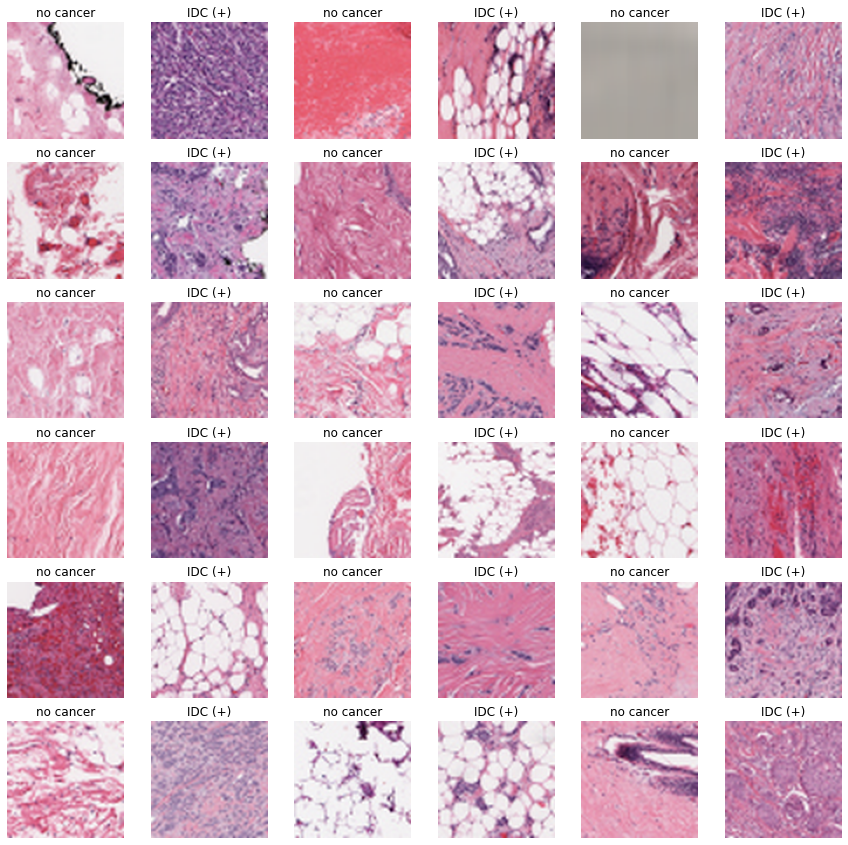

In [9]:
from keras.preprocessing import image
from PIL import Image

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = Image.open((N_IDC[num]))
        img = img.resize((100, 100), Image.ANTIALIAS)
        img = np.array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:

        img = Image.open((P_IDC[num]))
        img = img.resize((100, 100), Image.ANTIALIAS)
        img = np.array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1        

In [26]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    base_path = "/content/IDC_regular_ps50_idx5/"
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [93]:
def visualise_breast_tissue_base(patient_id, pred_df=None, trained_df=None):
    if isinstance(trained_df, pd.DataFrame):
      example_df = trained_df
    else:
      example_df = get_patient_dataframe(patient_id)

    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = cv2.imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

In [112]:
def visualise_breast_tissue(patient_id, trained_df = None):
    grid, mask, broken_patches,_ = visualise_breast_tissue_base(patient_id, trained_df=trained_df)

    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(grid, alpha=0.9)
    ax[1].imshow(mask, alpha=0.8)
    ax[1].imshow(grid, alpha=0.7)
    ax[0].grid(False)
    ax[1].grid(False)
    for m in range(2):
        ax[m].set_xlabel("X-coord")
        ax[m].set_ylabel("Y-coord")
    if isinstance(trained_df, pd.DataFrame):
      ax[0].set_title("Breast tissue slice of patient: " + patient_id)
      ax[1].set_title("Cancer tissue predicted colored red \n of patient: " + patient_id);
    else:
      ax[0].set_title("Breast tissue slice of patient: " + patient_id)
      ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

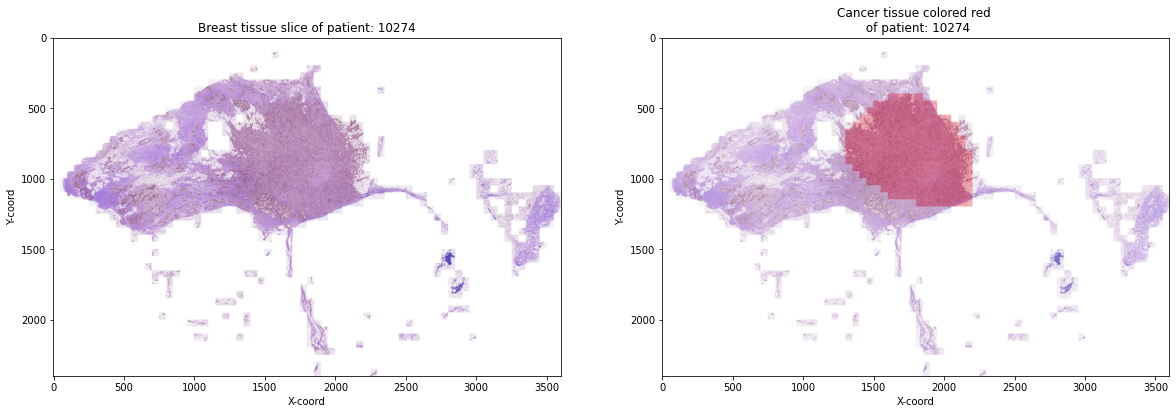

In [103]:
patient_id = "10274"
# get_patient_dataframe(patient_id)
visualise_breast_tissue(patient_id)

In [22]:
def visualise_breast_tissue_binary(patient_id):
        
    fig, ax = plt.subplots(1,1)

    example_df = get_patient_dataframe(patient_id)

    ax.scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
    ax.set_title("Patient " + patient_id)
    ax.set_xlabel("X coord")
    ax.set_ylabel("Y coord")

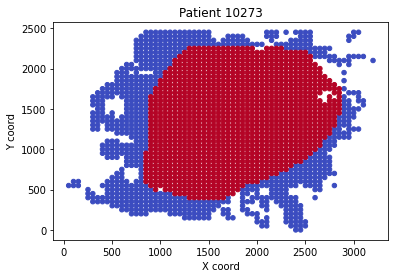

In [101]:
patient_id = "10273"
# get_patient_dataframe(patient_id)
visualise_breast_tissue_binary(patient_id)

# Split dataset

This is a code snippet in Python which appears to be processing two arrays of image file names, "N_IDC" and "P_IDC". For each image file in "N_IDC", it reads the image using the "cv2.imread" function from the OpenCV library, resizes the image to 50x50 using the "cv2.resize" function, and adds the resized image and label 0 to the "non_img_arr" list. For each image file in "P_IDC", it performs the same steps, but with a label of 1, and adds the resized image and label to the "can_img_arr" list.

In [119]:
# Create two empty arrays to store the processed images and their labels
non_img_arr = []
can_img_arr = []

# Loop through the list of file names in N_IDC
for img in N_IDC:
    
    # Read the image using OpenCV's imread function
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    
    # Resize the image to 50x50 using OpenCV's resize function
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    
    # Add the resized image and label (0) to the non_img_arr list
    non_img_arr.append([n_img_size, 0])
    
# Loop through the list of file names in P_IDC
for img in P_IDC:
    # Read the image using OpenCV's imread function
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    
    # Resize the image to 50x50 using OpenCV's resize function
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    
    # Add the resized image and label (1) to the can_img_arr list
    can_img_arr.append([c_img_size, 1])

This code is splitting data into training, validation, and testing sets for a binary classification problem. It starts by printing the count and percentage of "negative" and "positive" samples in the data. Then, it splits the "negative" and "positive" samples into training, validation, and testing sets by dividing the data into different portions (60% training, 20% validation, 20% testing). The length of each portion is determined based on the total number of "negative" or "positive" samples.

The code then balances the training sets so that it has the same number of "positive" and "negative" samples by selecting the same number of "negative" samples as there are "positive" samples. Finally, the training, validation, and testing sets are combined and randomly shuffled.

In [121]:
print(f"negative: {len(non_img_arr)} with perc: {(1-len(can_img_arr)/len(non_img_arr))*100}%, positive: {len(can_img_arr)} with perc: {(len(can_img_arr)/len(non_img_arr))*100}%")
length = len(non_img_arr)
train_non_img_arr = non_img_arr[:int(0.6 * length)]
validation_non_img_arr = non_img_arr[int(0.6 * length): int(0.8 * length)]
test_non_img_arr = non_img_arr[int(0.8 * length):int(length)]
print(f"len of train_negative: {len(train_non_img_arr)}, len of validation_negative: {len(validation_non_img_arr)}, len of test_negative: {len(test_non_img_arr)} ")

length = len(can_img_arr)
train_can_img_arr = can_img_arr[:int(0.6 * length)]
validation_can_img_arr = can_img_arr[int(0.6 * length): int(0.8 * length)]
test_can_img_arr = can_img_arr[int(0.8 * length):int(length)]
print(f"len of train_positive: {len(train_can_img_arr)}, len of validation_positive: {len(validation_can_img_arr)}, len of test_positive: {len(test_can_img_arr)} ")

length = len(train_can_img_arr)
random.shuffle(train_non_img_arr)
train_non_img_arr = train_non_img_arr[:int(length)]
print(f"new len of train_negative {len(train_non_img_arr)}. Now, the len of postive and negative sample is same")


train = np.concatenate((train_non_img_arr,train_can_img_arr))
validation = np.concatenate((validation_non_img_arr,validation_can_img_arr))
test = np.concatenate((test_non_img_arr,test_can_img_arr))

train_idx = np.random.permutation(train.shape[0])
train = train[train_idx]

validation_idx = np.random.permutation(validation.shape[0])
validation = validation[validation_idx]

test_idx = np.random.permutation(test.shape[0])
test = test[test_idx]


negative: 198738 with perc: 60.35685173444434%, positive: 78786 with perc: 39.64314826555565%
len of train_negative: 119242, len of validation_negative: 39748, len of test_negative: 39748 
len of train_positive: 47271, len of validation_positive: 15757, len of test_positive: 15758 
new len of train_negative 47271. Now, the len of postive and negative sample is same


In [ ]:
X_train = []
X_test = []
X_val = []
Y_train = []
Y_test = [] 
Y_val = []


for feature, label in train:
    X_train.append(feature)
    Y_train.append(label)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

for feature, label in validation:
    X_val.append(feature)
    Y_val.append(label)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

for feature, label in test:
    X_test.append(feature)
    Y_test.append(label)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

The TensorFlow's to_categorical function is used to convert labels into a one-hot encoded representation. This function takes in the label array and the number of possible classes (in this case 2) as input, and returns a matrix of dimensions (num_samples, num_classes) where each row represents the one-hot encoded representation of a label.

For example, if you have three categories: "red", "green", and "blue", the one-hot encoded representation for "red" would be [1, 0, 0], for "green" it would be [0, 1, 0], and for "blue" it would be [0, 0, 1].

In [ ]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)
Y_val = to_categorical(Y_val, num_classes = 2)


print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (94542, 50, 50, 3)
Validation Data Shape: (55505, 50, 50, 3)
Testing Data Shape: (55506, 50, 50, 3)


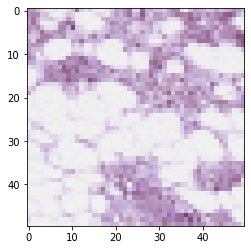

In [ ]:
plt.imshow(X_train[0])

# Set function for treaning

In [67]:
import shutil

local_model_path = "/content/models"
if not os.path.exists(local_model_path):
  os.makedirs(local_model_path)
global_model_path = "/content/drive/My Drive/models/from_scratch"
if not os.path.exists(global_model_path):
  os.makedirs(global_model_path)

In this specific implementation, the LossHistory class is used to record the loss after each batch. It defines two methods: on_train_begin and on_batch_end.

* The ***on_train_begin*** method is called at the start of the training process, and it initializes an empty list losses to store the losses after each batch.

* The ***on_batch_end*** method is called at the end of each batch and it retrieves the loss value from the logs passed as an argument, using logs.get('loss'). It then appends this loss value to the losses list, so that the loss after each batch can be recorded.

In [ ]:
from keras.callbacks import Callback

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

The function "run_training" trains a model by fitting it on the training data. It takes five parameters:

1. "model": the model to be trained.
2. "model_name": the name given to the model for saving it.
3. "num_epochs": number of training epochs.
4. "patience": patience value for early stopping, which is used to stop the training process when the monitored metric stops improving.
5. "monitor": metric to monitor for early stopping and model checkpoint, which is used to save the best performing model.

The function first defines the save path for the model and then the callbacks to use during the training process, which include early stopping and model checkpoint. The model is then fit on the training data and validated on the validation data. The best model is then copied to the global models folder and the training and validation performance is plotted.

In [ ]:
def run_training(model, model_name, num_epochs = 20, patience=5, monitor='val_loss'):
    """
    This function trains the model by fitting it on the training data.
    :param model: the model to be trained
    :param model_name: the name given to the model to save it
    :param num_epochs: number of training epochs
    :param patience: patience value for early stopping
    :param monitor: metric to monitor for early stopping and model checkpoint
    """
    # Define the save path for the model
    save_model = f'{local_model_path}/{model_name}.h5'
    
    # Create an instance of the LossHistory class
    loss_history = LossHistory()
    
    # Fit the model on the training data and validate it on the validation data
    history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 1, batch_size = 35, callbacks=[loss_history])
    # Save the model
    model.save(save_model)
    # Copy the best model to the global models folder
    shutil.copy(save_model, f'{global_model_path}/{model_name}.h5')
    # Plot the batch-wise loss
    plt.plot(loss_history.losses)
    plt.title('Batch-wise Loss')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.show()

Adam and RMSprop are two popular optimization algorithms used in deep learning and machine learning.

* Adam (Adaptive Moment Estimation) is an optimization algorithm that 
uses gradient descent to update the model parameters. It calculates moving averages of the gradients and uses these averages to adjust the learning rate, making it adaptive to the training data. This helps to avoid overshooting the minimum and helps to converge faster.

* RMSprop (Root Mean Square Propagation) is a similar optimization algorithm to Adam but with a different way of calculating the learning rate for each parameter. Instead of moving averages, RMSprop uses a moving average of the squared gradient to calculate the learning rate, which helps to avoid oscillation and to speed up convergence for deep learning models.

Both Adam and RMSprop are widely used and are considered to be effective optimization algorithms for deep learning problems. The choice between them can depend on the specifics of the problem and the type of model being used.



Binary Cross-Entropy (BCE) is a loss function used in binary classification problems. The formula is as follows:

BCE = -(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))

where:

* y_true is the target (true) value
* y_pred is the model's prediction

BCE calculates the difference between the true and predicted values of the model for each training example, and then the sum of these differences is used to optimize the weights of the model. The goal is to minimize the BCE to achieve as accurate a classification as possible.

In [ ]:
from tensorflow.keras import optimizers
def compile_model(model, optimizer='adam', learning_rate = 0.0001):
  '''
  compile_model is used to compile the current model
  :param model: model to be compiled
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

The function "evaluate_performance" is used to evaluate the performance of a given model.

Here is the description of each step of the function:

1. The function first predicts the test dataset using the "predict" method of the given model. The predictions are stored in the "y_score" variable.

2. Next, the predicted scores are rounded to either 0 or 1 using the "rint" function from numpy. The rounded predictions are stored in the "y_pred" variable.

3. The true labels for the test dataset are extracted from the test_dataset and concatenated into a single tensor using the "concat" method of the TensorFlow library. The true labels are stored in the "y_true" variable.

4. The function then prints a classification report using the "classification_report" function from the "metrics" module. The classification report shows various performance metrics, such as precision, recall, and f1-score, for each class in the dataset.

5. The confusion matrix is also displayed using the "ConfusionMatrixDisplay" method from the "metrics" module.

6. Finally, the function plots the Receiver Operating Characteristic (ROC) curve. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR). The area under the ROC curve (AUC) is also calculated and displayed on the plot.

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
def evaluate_performance(model):
    """
    The function is used to evaluate the performance of a given model on a test dataset and display a
    classification report and a ROC curve.

    :param model: The model to be evaluated
    """
    # Get the predicted scores and round them to the nearest integer

    y_score = model.predict(X_test)
    y_pred = np.argmax(y_score,axis = 1) 
    y_true = np.argmax(Y_test,axis = 1) 

    print("Report di classificazione:")
    print(metrics.classification_report(y_true, y_pred, digits=4))
    matrice_di_confusione = confusion_matrix(y_true, y_pred)
    print("Matrice di confusione:")
    print(matrice_di_confusione)

    # Print a classification report
    print("Classification report:")
    print(metrics.classification_report(y_true, y_pred, digits=4))
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

    # Compute the false positive rate and true positive rate for the ROC curve
    fpr, tpr, th = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()


# CNN

In [65]:
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf


## Experiment 1: CNN basic

In [ ]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(50, 50, 3))
x = layers.Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu',strides=(1, 1))(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1))(x)

x = layers.Dropout(0.25)(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

outputs = layers.Dense(2, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

compile_model(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 64)        0         
                                                                 
 flatten (Flatten)           (None, 153664)            0         
                                                                 
 dense (Dense)               (None, 64)                9834560   
                                                             

2702/2702 [==============================] - 1562s 577ms/step - loss: 2.0710 - accuracy: 0.7648 - val_loss: 0.4040 - val_accuracy: 0.8193


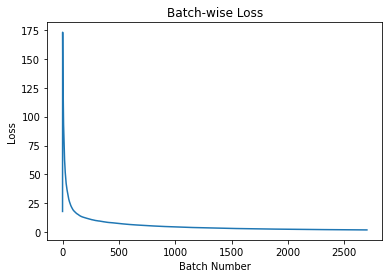

In [ ]:
run_training(model, "OneDense64_1dropout", num_epochs=1)

1735/1735 [==============================] - 108s 62ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9055    0.8329    0.8677     39748
           1     0.6494    0.7807    0.7091     15758

    accuracy                         0.8181     55506
   macro avg     0.7775    0.8068    0.7884     55506
weighted avg     0.8328    0.8181    0.8227     55506

Matrice di confusione:
[[33107  6641]
 [ 3455 12303]]
Classification report:
              precision    recall  f1-score   support

           0     0.9055    0.8329    0.8677     39748
           1     0.6494    0.7807    0.7091     15758

    accuracy                         0.8181     55506
   macro avg     0.7775    0.8068    0.7884     55506
weighted avg     0.8328    0.8181    0.8227     55506



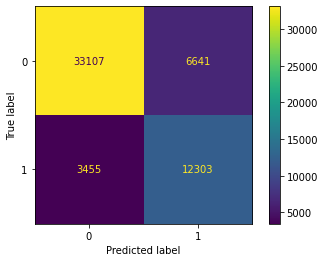

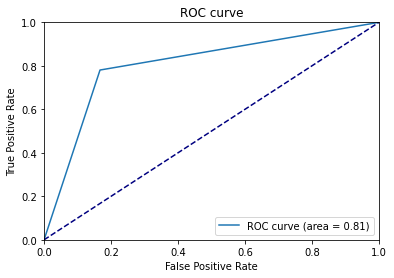

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/OneDense64_1dropout.h5'))

## Experiment 2: CNN more layer

In [ ]:
inputs = keras.Input(shape=(50, 50, 3))

x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(24, activation='relu', kernel_initializer='he_uniform')(x)

outputs = layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128 

2702/2702 [==============================] - 2261s 837ms/step - loss: 0.4320 - accuracy: 0.8136 - val_loss: 0.5541 - val_accuracy: 0.7528


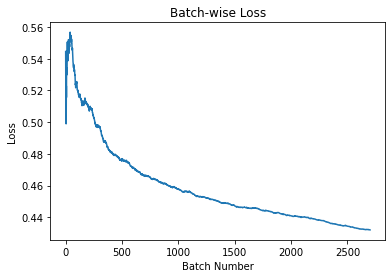

In [ ]:
run_training(model, "MoreLayers", num_epochs=1)

1735/1735 [==============================] - 259s 149ms/step
Report di classificazione:
              precision    recall  f1-score   support

           0     0.9691    0.6462    0.7754     39748
           1     0.5151    0.9481    0.6675     15758

    accuracy                         0.7319     55506
   macro avg     0.7421    0.7971    0.7215     55506
weighted avg     0.8402    0.7319    0.7448     55506

Matrice di confusione:
[[25685 14063]
 [  818 14940]]
Classification report:
              precision    recall  f1-score   support

           0     0.9691    0.6462    0.7754     39748
           1     0.5151    0.9481    0.6675     15758

    accuracy                         0.7319     55506
   macro avg     0.7421    0.7971    0.7215     55506
weighted avg     0.8402    0.7319    0.7448     55506



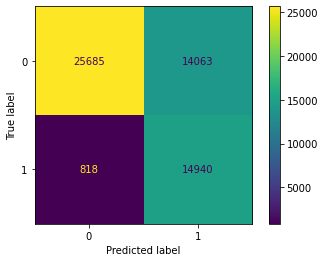

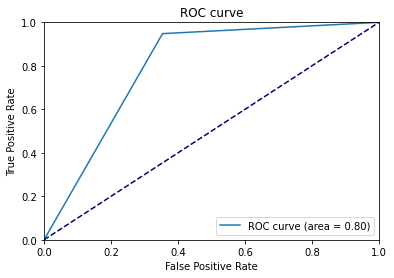

In [ ]:
evaluate_performance(tf.keras.models.load_model(f'{global_model_path}/MoreLayers.h5'))

# Let's see the results

## Set main function

In [115]:
def extract_main_feature(patient_id):
  example_df = get_patient_dataframe(patient_id)

  Y_test = example_df["target"].to_numpy()
  x_coord= example_df["x"].to_numpy()
  y_coord= example_df["y"].to_numpy()
  path_images = example_df["path"].to_numpy()
  X_test = []
  for path_img in path_images:
      
      # Read the image using OpenCV's imread function
      img = cv2.imread(path_img, cv2.IMREAD_COLOR)
      
      # Resize the image to 50x50 using OpenCV's resize function
      img_size = cv2.resize(img, (50, 50), interpolation = cv2.INTER_LINEAR)
      
      # Add the resized image and label (0) to the non_img_arr list
      X_test.append(img_size)
  X_test = np.array(X_test)
  return x_coord,y_coord,Y_test,path_images, X_test

In [114]:
def visualise_breast_tissue_predict(model, x_coord,y_coord,Y_test,path_images, X_test):
  model = tf.keras.models.load_model(f'{global_model_path}/{model}')
  y_score = model.predict(X_test)
  y_pred = np.argmax(y_score,axis = 1)  

  # Crea un dizionario che associa i nomi delle colonne alle colonne stesse come array numpy
  data = {'x': x_coord, 'y': y_coord, 'target': y_pred, 'path': path_images}

  # Crea un DataFrame passando il dizionario
  example_df = pd.DataFrame(data)
  visualise_breast_tissue(patient_id, example_df)
  

In [113]:
def realty_vs_predict(patient_id,model):
  x_coord,y_coord,Y_test,path_images, X_test= extract_main_feature(patient_id)
  #visualise real image
  visualise_breast_tissue(patient_id)
  #visualize predicted image
  visualise_breast_tissue_predict(model,x_coord,y_coord,Y_test,path_images, X_test)

## First experiment

28/28 [==============================] - 1s 43ms/step


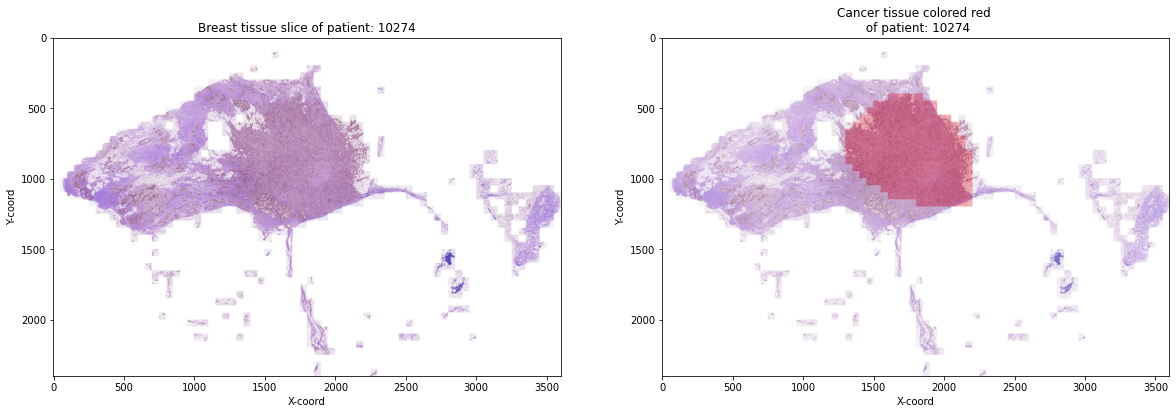

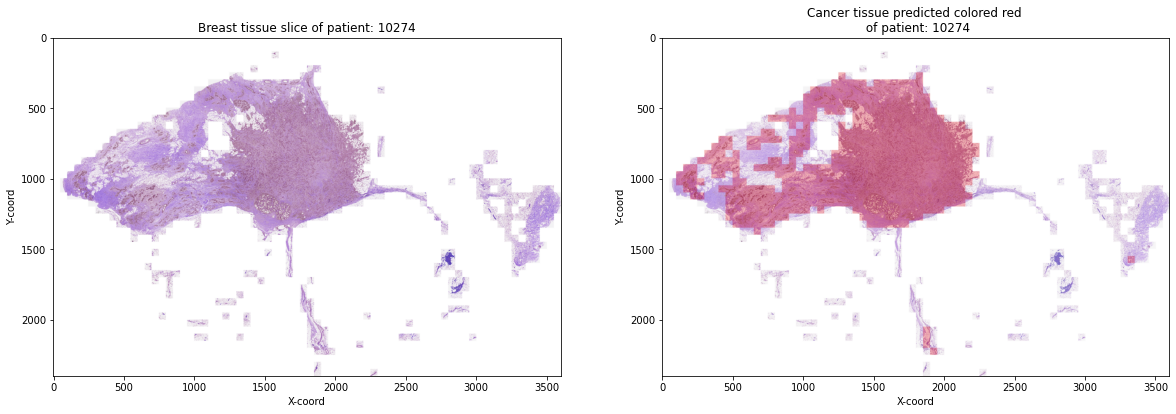

In [117]:
patient_id = "10274"
model = "OneDense64_1dropout.h5"
realty_vs_predict(patient_id,model)

## Second experiemnt

28/28 [==============================] - 4s 147ms/step


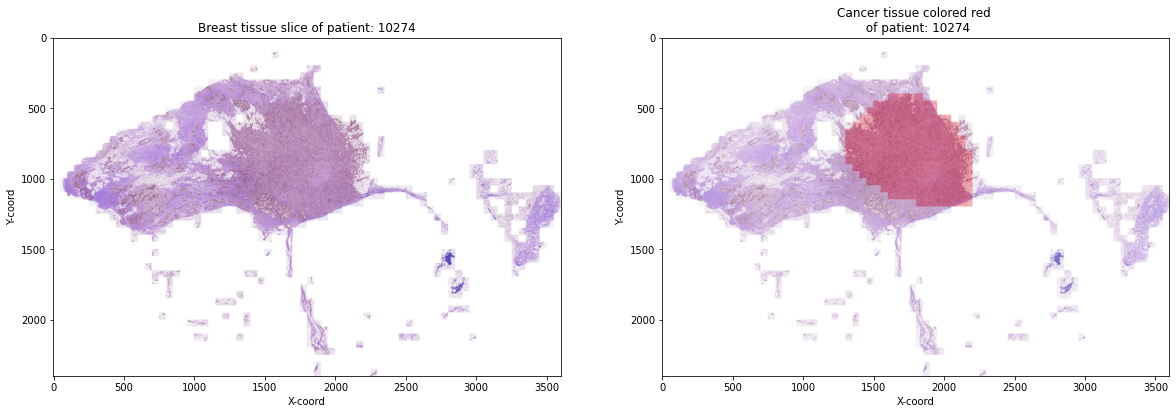

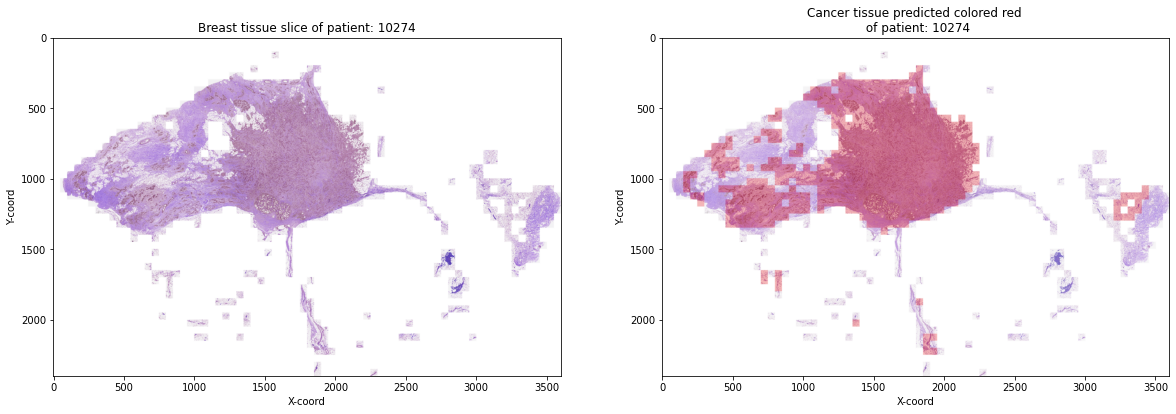

In [118]:
patient_id = "10274"
model = "MoreLayers.h5"
realty_vs_predict(patient_id,model)